In [ ]:
!pip install transformers

In [2]:
import keras
keras.__version__

from keras.models import Sequential, Model
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Input
import tensorflow_hub as hub

from keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model

import os
import numpy as np

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

imdb_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 8s 0us/step


In [4]:
#ラベルと連動してシャッフル
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def load_raw_imdb(dir):
  labels = []
  texts = []

  for label_type in ['neg', 'pos']:
      dir_name = os.path.join(dir, label_type)
      for fname in os.listdir(dir_name):
          if fname[-4:] == '.txt':
              f = open(os.path.join(dir_name, fname))
              texts.append(f.read())
              f.close()
              if label_type == 'neg':
                  labels.append(0)
              else:
                  labels.append(1)
    
  return texts, labels


train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

x_train, y_train = load_raw_imdb(train_dir)
x_test, y_test = load_raw_imdb(test_dir)

x_train, y_train, x_test, y_test  = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

x_train, y_train, = unison_shuffled_copies(x_train, y_train,)

In [ ]:
#tensorflow hubを使った事前学習モデルの利用
#https://tfhub.dev/

model = Sequential()
model.add(layers.Input((), dtype="string"))
model.add(hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/3"))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(512))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

In [6]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/10
79/79 [==============================] - 97s 1s/step - loss: 0.6088 - acc: 0.7350 - val_loss: 0.4048 - val_acc: 0.8206
Epoch 2/10
79/79 [==============================] - 93s 1s/step - loss: 0.3883 - acc: 0.8289 - val_loss: 0.3651 - val_acc: 0.8378
Epoch 3/10
79/79 [==============================] - 93s 1s/step - loss: 0.3650 - acc: 0.8369 - val_loss: 0.3592 - val_acc: 0.8406
Epoch 4/10
79/79 [==============================] - 93s 1s/step - loss: 0.3587 - acc: 0.8387 - val_loss: 0.3554 - val_acc: 0.8426
Epoch 5/10
 4/79 [>.............................] - ETA: 1:11 - loss: 0.3442 - acc: 0.8589

KeyboardInterrupt: ignored

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=512)
print("Accuracy = ", results[1])

In [7]:
#transformersを使った事前学習モデルの利用
#https://huggingface.co/transformers/index.html
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertModel.from_pretrained('bert-base-cased')


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
tokenize = tokenizer.encode("Hello, my cat is cute", return_tensors="tf", add_special_tokens=True)
display("原文")
display("Hello, my cat is cute")

print("\nトークナイズしてid化した結果")
display(tokenize)

print("\nデコード")
display(tokenizer.convert_ids_to_tokens(tokenize.numpy().tolist()[0]))

outputs = model(tokenize)

last_hidden_states = outputs.last_hidden_state
print("\n出力ベクトル")
display(last_hidden_states.shape)

'原文'

'Hello, my cat is cute'


トークナイズしてid化した結果


<tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  8667,   117,  1139,  5855,  1110, 10509,   102]],
      dtype=int32)>


デコード


['[CLS]', 'Hello', ',', 'my', 'cat', 'is', 'cute', '[SEP]']


出力ベクトル


TensorShape([1, 8, 768])

In [ ]:
ids_length = 200
batch_tokenize = tokenizer.batch_encode_plus(["test"], return_tensors="tf", max_length=ids_length, truncation=True, padding ="max_length", add_special_tokens=True)
display(batch_tokenize)

In [10]:
class MyModel(object):
    def __init__(self, ids_length):

      bert_embedder = TFBertModel.from_pretrained('bert-base-cased', return_dict=True)
      bert_embedder.layers[0].trainable=False
      display(bert_embedder.layers[0].trainable) 

      input_ids = Input(shape=(ids_length, ), dtype='int32', name='input_ids')
      attention_mask = Input(shape=(ids_length, ), dtype='int32', name='attention_mask')
      token_type_ids = Input(shape=(ids_length, ), dtype='int32', name='token_type_ids')
      
      inputs = [input_ids, attention_mask, token_type_ids]

      #文頭タグに対するベクトルのみ使用
      sentence_vec = bert_embedder(inputs, training=False).last_hidden_state[:,0,:]

      dense_mid = Dense(768)(sentence_vec)

      dense_out = Dense(1, activation="sigmoid")(dense_mid)

      self._model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense_out)
      
    def get_model(self):
        return self._model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


False

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

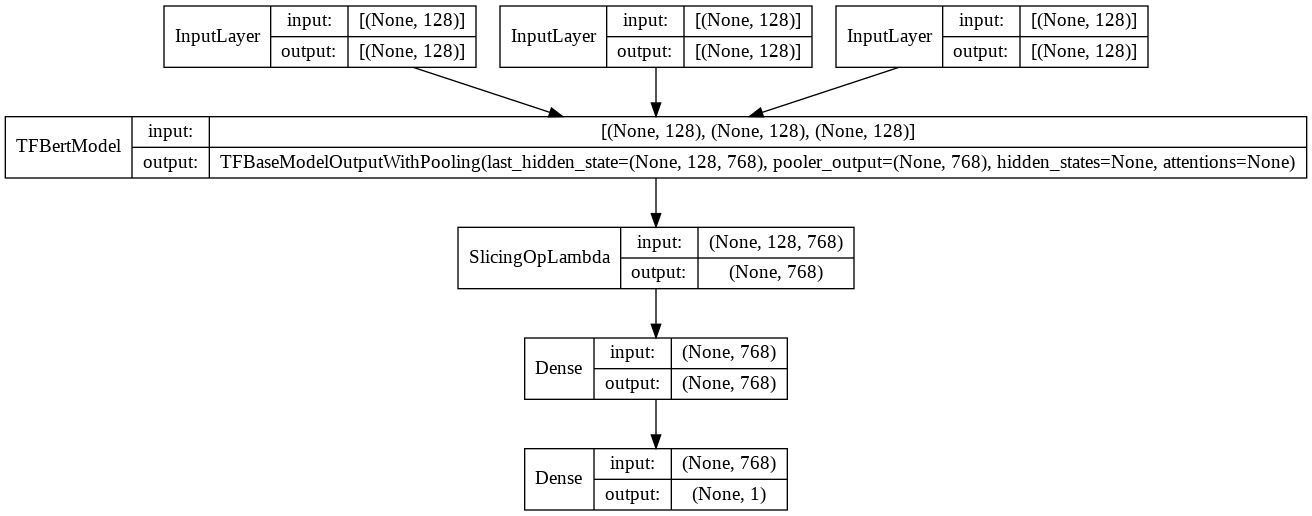

In [11]:
ids_length = 128

model = MyModel(ids_length).get_model()
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["acc"])

model.summary()
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
train_ids = tokenizer.batch_encode_plus(x_train, return_tensors="tf", max_length=ids_length, truncation=True, padding ="max_length", add_special_tokens=True)

In [ ]:
display(train_ids["input_ids"])
display(train_ids["attention_mask"])
display(train_ids["token_type_ids"])

In [ ]:
history = model.fit([train_ids["input_ids"], train_ids["attention_mask"], train_ids["token_type_ids"]], y_train, epochs=20, validation_split=0.1, batch_size=512, shuffle=True, callbacks=[])